# Import Packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#%matplotlib inline
import seaborn as sns
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
import json

# Missing Analysis
import missingno as msno

# Modelling
from scipy import integrate
from scipy import optimize

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Get Data from Dataset

In [ ]:
df_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases.csv")
df_cases_country = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_cases_state = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_state.csv")
df_cases_time = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv", parse_dates = ['Last_Update','Report_Date_String'])

In [ ]:
print (df_cases.shape)
print ('Last Update: ' + str(df_cases.Last_Update.max()))
df_cases.head(1)

In [ ]:
print (df_cases_country.shape)
print ('Last Update: ' + str(df_cases_country.Last_Update.max()))
df_cases_country.head(1)

In [ ]:
print (df_cases_state.shape)
df_cases_state.head(1)

In [ ]:
print (df_cases_time.shape)
df_cases_time.head(1)

In [ ]:
df_data = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv', parse_dates = ['ObservationDate','Last Update'])
print (df_data.shape)
print ('Last update: ' + str(df_data.ObservationDate.max()))
df_data.head(2)

In [ ]:
# Clean data
df_data = df_data.drop(['SNo', 'Last Update'], axis=1)
df_data = df_data.rename(columns={
    'ObservationDate': 'Date', 
    'Country/Region': 'Country_Region', 
    'Province/State': 'Province_State'
})
df_data.head(2)

In [ ]:
# Sort data
df_data = df_data.sort_values(['Date','Country_Region','Province_State'])
# Get first reported case date
df_data['first_date'] = df_data.groupby('Country_Region')['Date'].transform('min')
# Get days since first reported case date
df_data['days'] = (df_data['Date'] - df_data['first_date']).dt.days
print(df_data.shape)
df_data.head(2)

In [ ]:
data_path = "/kaggle/input/covid19-in-usa/"
df_us_test = pd.read_csv(data_path + "us_covid19_daily.csv")
df_us_states_test = pd.read_csv(data_path + "us_states_covid19_daily.csv")
df_us_test["date"] = pd.to_datetime(df_us_test["date"], format="%Y%m%d")
df_us_states_test = df_us_states_test.reindex(index=df_us_states_test.index[::-1])
df_us_states_test["date"] = pd.to_datetime(df_us_states_test["date"], format="%Y%m%d").dt.date.astype(str)

print (df_us_states_test.shape)
#df_us_states_test.query('state == "NY"').sort_values('date', ascending=False).head()
#print (df_us_states_test.columns)
df_us_states_test.groupby('state').max().fillna(0).sort_values('total', ascending=False).head().style\
.background_gradient(cmap='Reds',subset=["positive"])\
.background_gradient(cmap='Blues',subset=["negative"])\
.background_gradient(cmap='Purples',subset=["pending"])\
.background_gradient(cmap='OrRd',subset=["hospitalizedCurrently"])\
.background_gradient(cmap='OrRd',subset=["hospitalizedCumulative"])\

In [ ]:
df_us_states_test.head()

# Total Cases

In [ ]:
def get_total_cases(df_cases):
    total_confirmed = np.sum(df_cases['Confirmed'])
    total_deaths = np.sum(df_cases['Deaths'])
    total_recovered = np.sum(df_cases['Recovered'])
    total_active = np.sum(df_cases['Active'])
    total_mortality_rate = np.round((np.sum(df_cases['Deaths']) / np.sum(df_cases['Confirmed']) * 100), 2)
    total_recover_rate = np.round((np.sum(df_cases['Recovered']) / np.sum(df_cases['Confirmed']) * 100), 2)

    data = {
        'Confirmed': [total_confirmed],
        'Deaths': [total_deaths],
        'Recovered': [total_recovered],
        'Active': [total_active],
        'Mortality Rate %': [total_mortality_rate],
        'Recover Rate %': [total_recover_rate]
    }
    df_total = pd.DataFrame(data)
    return df_total

## Worldwide Total Cases

In [ ]:
# colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
df_total = get_total_cases(df_cases_country).style.hide_index().background_gradient(cmap='Wistia', axis=1)
df_total

## USA Total Cases

In [ ]:
# colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
df_total = get_total_cases(df_cases_country[df_cases_country.Country_Region == 'US']) \
            .style.hide_index().background_gradient(cmap='Wistia', axis=1)
df_total

# Cases in US States

In [ ]:
df_data.head()

In [ ]:
# US state code to name mapping
# https://www.kaggle.com/sudalairajkumar/covid-19-analysis-of-usa
state_map_dict = {
 'AL': 'Alabama',
 'AK': 'Alaska',
 'AS': 'American Samoa',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'DC': 'District of Columbia',
 'D.C.': 'District of Columbia',
 'FM': 'Federated States of Micronesia',
 'FL': 'Florida',
 'GA': 'Georgia',
 'GU': 'Guam',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MH': 'Marshall Islands',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'MP': 'Northern Mariana Islands',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PW': 'Palau',
 'PA': 'Pennsylvania',
 'PR': 'Puerto Rico',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VI': 'Virgin Islands',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'
}

state_code_dict = {v:k for k, v in state_map_dict.items()}
state_code_dict["Chicago"] = 'Illinois'

def correct_state_names(x):
    try:
        return state_map_dict[x.split(",")[-1].strip()]
    except:
        return x.strip()
    
def get_state_codes(x):
    try:
        return state_code_dict[x]
    except:
        return "Others"
    
def get_state_name(x):
    try:
        for name, code in state_code_dict.items():
            if code == x:
                return name
        return 'Others'
    except:
        return "Others"

In [ ]:
df_data_us = df_data[df_data['Country_Region'] == 'US'].copy()
df_data_us["Province_State"] = df_data_us["Province_State"].apply(correct_state_names)
df_data_us["State_Code"] = df_data_us["Province_State"].apply(lambda x: get_state_codes(x))

In [ ]:
df_data_us.groupby('Province_State').max().sort_values('Confirmed', ascending=False).head()

In [ ]:
df_us_states = df_cases_state[df_cases_state['Country_Region'] == 'US'].copy()
df_us_states["State_Code"] = df_us_states["Province_State"].apply(lambda x: get_state_codes(x))
df_us_states['Recovery_Rate'] = df_cases_state['Recovered'] / df_cases_state['Confirmed'] * 100
df_us_states = df_us_states[[
                    'Province_State', 'Confirmed', 'Deaths', 'Recovered', 'Active', \
                    'Mortality_Rate', 'Recovery_Rate', 'Incident_Rate', \
                    'People_Tested', 'People_Hospitalized',  \
                    'Testing_Rate', 'Hospitalization_Rate', 'State_Code'
                ]]

# replace nan values with zero
df_us_states.fillna(0, inplace=True)

# replace underscore with space in columns name
#df_us_states.rename(columns=lambda x: x.replace('_', ' '), inplace=True)
#df_us_states.columns

df_us_states.sort_values('Confirmed', ascending=False)\
.rename(columns=lambda x: x.replace('_', ' '))\
.style.hide_index()\
.background_gradient(cmap='Blues',subset=["Confirmed"])\
.background_gradient(cmap='Reds',subset=["Deaths"])\
.background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='Purples',subset=["Active"])\
.background_gradient(cmap='GnBu',subset=["Incident Rate"])\
.background_gradient(cmap='OrRd',subset=["Mortality Rate"])\
.background_gradient(cmap='PuBu',subset=["Recovery Rate"])\
.background_gradient(cmap='Greens',subset=["People Tested"])\
.background_gradient(cmap='OrRd',subset=["People Hospitalized"])\
.background_gradient(cmap='Greens',subset=["Testing Rate"])\
.background_gradient(cmap='OrRd',subset=["Hospitalization Rate"])

In [ ]:
fig = go.Figure(data=[
    go.Pie(labels=df_us_states['Province_State'], 
           values=df_us_states['Confirmed'], 
           hole=.35,
           textinfo='label+percent'
          )
])

fig.update_layout(
    title_text="US Confirmed Cases by States",
    # Add annotations in the center of the donut pies.
    annotations=[
        dict(text='Confirmed<br>Cases', showarrow=False),
    ]
)
fig.update_traces(textposition='inside')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Pie(labels=df_us_states['Province_State'], 
           values=df_us_states['Deaths'], 
           hole=.35,
           textinfo='label+percent'
          )
])

fig.update_layout(
    title_text="US Deaths Cases by States",
    # Add annotations in the center of the donut pies.
    annotations=[
        dict(text='Deaths<br>Cases', showarrow=False),
    ]
)
fig.update_traces(textposition='inside')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Pie(labels=df_us_states['Province_State'], 
           values=df_us_states['People_Tested'], 
           hole=.35,
           textinfo='label+percent'
          )
])

fig.update_layout(
    title_text="US Tests Percentage by States",
    # Add annotations in the center of the donut pies.
    annotations=[
        dict(text='People<br>Tested', showarrow=False),
    ]
)
fig.update_traces(textposition='inside')
fig.show()

In [ ]:
df_confirmed_top = df_us_states.sort_values('Confirmed', ascending=False).head(10)
fig = go.Figure(data=[
    go.Bar(name='Confirmed', x=df_confirmed_top['Province_State'], y=df_confirmed_top['Confirmed'],
           text=df_confirmed_top['Confirmed'], texttemplate='%{text:.2s}', textposition='outside'),
    go.Bar(name='Deaths', x=df_confirmed_top['Province_State'], y=df_confirmed_top['Deaths'],
           text=df_confirmed_top['Deaths'], texttemplate='%{text:.2s}', textposition='outside'),
    go.Bar(name='Recovered', x=df_confirmed_top['Province_State'], y=df_confirmed_top['Recovered'],
           text=df_confirmed_top['Recovered'], texttemplate='%{text:.2s}', textposition='outside'),
    #go.Bar(name='People Tested', x=df_confirmed_top['Province_State'], y=df_confirmed_top['People_Tested'],
    #       text=df_confirmed_top['People_Tested'], texttemplate='%{text:.2s}', textposition='outside'),
])
# Change the bar mode
fig.update_layout(
    title_text="Top 10 US States with Confirmed Cases",
    barmode='group', 
    #legend_orientation="h",
    yaxis_type='log',
    yaxis_title='Cases Count in Log Scale'
)
fig.show()

# Time Series of Cases in US

In [ ]:
df_us_states_test.columns

In [ ]:
#df_us_states_test.
df_us_states_test["state_name"] = df_us_states_test["state"].apply(lambda x: get_state_name(x))
df_us_states_test.head()

In [ ]:
df_t = df_us_states_test.groupby('date').sum().reset_index()
df_t.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['positive'], 
                         mode='lines+markers', name='Confirmed'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['death'], 
                         mode='lines+markers', name='Deaths'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['recovered'], 
                         mode='lines+markers', name='Recovered'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['hospitalized'], 
                         mode='lines+markers', name='Hospitalized'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['total'], 
                         mode='lines+markers', name='Total Tested'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="Cases Count in Log Scale",
        title = 'Time Series - Confirmed, Deaths & Recovered Cases in USA',
        yaxis_type='log'
    )
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['positiveIncrease'], 
                         mode='lines+markers', name='Confirmed'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['deathIncrease'], 
                         mode='lines+markers', name='Deaths'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['hospitalizedIncrease'], 
                         mode='lines+markers', name='Hospitalized'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['totalTestResultsIncrease'], 
                         mode='lines+markers', name='Total Tests'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="Cases Count in Log Scale",
        title = 'Time Series - Confirmed, Deaths & Recovered Cases [Daily Increase] in USA',
        yaxis_type='log'
    )
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['recovered']/df_t['positive']*100, 
                         mode='lines+markers', name='Recovery Rate'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['death']/df_t['positive']*100, 
                         mode='lines+markers', name='Death Rate'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="Recovery/Death Rate Percentage (%)",
        title = 'Time Series - Recovery and Death Rate in USA',
        yaxis_type='log'
    )
fig.show()

In [ ]:
df_t = df_us_states_test.groupby(['state_name', 'date']).sum().reset_index()

top_count = 10
top_confirmed = df_us_states.sort_values('Confirmed', ascending=False).head(top_count)['Province_State'].to_list()
top_deaths = df_us_states.sort_values('Deaths', ascending=False).head(top_count)['Province_State'].to_list()
top_recovered = df_us_states.sort_values('Recovered', ascending=False).head(top_count)['Province_State'].to_list()
#print (top_confirmed)
#print (top_deaths)
#print (top_recovered)

df_top_confirmed = df_t[df_t.state_name.isin(top_confirmed)]
df_top_deaths = df_t[df_t.state_name.isin(top_deaths)]
df_top_recovered = df_t[df_t.state_name.isin(top_recovered)]

def get_top(state_list):    
    df_top = df_t[df_t['state_name'].isin(state_list)]
    df_top = df_top.groupby(['state_name', 'date']).sum()
    return df_top.reset_index()
    '''df_top10 = pd.DataFrame()
    for state, df_new in df_top.groupby(level=0):
        # 1. The cases count is cummulative in the dataset.
        #    Hence, we calculate the difference between current row and next row value
        # 2. Some rows after diff() were showing negative values.
        #    This is because in some cases, the next day entry had lesser value than current day entry.
        #    Therefore, used abs() to make them positive.
        #    Hoping that the dataset is corrected later on.
        df_new = df_new.diff().fillna(df_new).abs()
        df_top10 = df_top10.append(df_new, ignore_index=False)
    return df_top10.reset_index()'''

#df_top10_confirmed_daily = get_top10(top10_confirmed_country_list)
#df_top10_deaths_daily = get_top10(top10_deaths_country_list)
#df_top10_recovered_daily = get_top10(top10_recovered_country_list)
#df_top10_confirmed_daily.head(2)

df_top_confirmed.head()

In [ ]:
fig = px.line(df_top_confirmed, x="date", y="positive", color="state_name")
fig.update_layout(
    title='Time Series - Confirmed Cases: Top '+str(top_count)+' States',
    xaxis_title='',
    yaxis_title='Confirmed Cases in Log Scale',
    yaxis_type='log'
)
fig.show()

In [ ]:
fig = px.line(df_top_confirmed, x="date", y="positiveIncrease", color="state_name")
fig.update_layout(
    title='Time Series - Confirmed Cases [Daily Increase]: Top '+str(top_count)+' States',
    xaxis_title='',
    yaxis_title='Confirmed Cases in Log Scale',
    yaxis_type='log'
)
fig.show()

In [ ]:
fig = px.line(df_top_confirmed, x="date", y="death", color="state_name")
fig.update_layout(
    title='Time Series - Death Cases: Top '+str(top_count)+' States',
    xaxis_title='',
    yaxis_title='Death Cases in Log Scale',
    yaxis_type='log'
)
fig.show()

In [ ]:
fig = px.line(df_top_confirmed, x="date", y="total", color="state_name")
fig.update_layout(
    title='Time Series - People Tested: Top '+str(top_count)+' States',
    xaxis_title='',
    yaxis_title='Number of People Tested in Log Scale',
    yaxis_type='log'
)
fig.show()

In [ ]:
fig = px.line(df_top_confirmed, x="date", y="totalTestResultsIncrease", color="state_name")
fig.update_layout(
    title='Time Series - People Tested [Daily Increase]: Top '+str(top_count)+' States',
    xaxis_title='',
    yaxis_title='Number of People Tested in Log Scale',
    yaxis_type='log'
)
fig.show()

# Heat Map of US States

In [ ]:
# https://plotly.com/python/choropleth-maps/
data = df_us_states.copy()
data['Confirmed_Log'] = np.log10(df_us_states['Confirmed'])
data['Mortality_Rate'] = np.round(data['Mortality_Rate'], 2)
fig = px.choropleth(data, 
                    locations='State_Code',
                    locationmode="USA-states",
                    scope="usa",
                    color='Confirmed_Log', # a column in the dataset
                    hover_name='Province_State', # column to add to hover information
                    hover_data=['Confirmed', 'Deaths', 'Recovered', 'Mortality_Rate'],
                    color_continuous_scale='OrRd')
fig.update_layout(title_text="Heat Map - Confirmed Cases in US States")
#fig.update_coloraxes(colorbar_title="Color (Confirmed Cases Log Scale)")
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
usa_geo_json = '/kaggle/input/country-state-geo-location/us-states.json'
with open(usa_geo_json) as f:
  usa_geo = json.load(f)

data = df_us_states.copy()
for index, item in enumerate(usa_geo['features']):
    row = data[data['State_Code'] == item['id']]
    if row.empty: continue # skip for states that are not present in the cases dataset
    usa_geo['features'][index]['properties']['Confirmed'] = str(row.iloc[0]['Confirmed'])
    usa_geo['features'][index]['properties']['Deaths'] = str(row.iloc[0]['Deaths'])
    usa_geo['features'][index]['properties']['Recovered'] = str(row.iloc[0]['Recovered'])
    usa_geo['features'][index]['properties']['Mortality Rate'] = str(np.round(row.iloc[0]['Mortality_Rate'],2)) + '%'
    usa_geo['features'][index]['properties']['Recovery Rate'] = str(np.round(row.iloc[0]['Recovered'] / row.iloc[0]['Confirmed'] * 100, 2)) + '%'

print (usa_geo['features'][0]['properties'])

In [ ]:
# logarithmic value is taken to avoid skewness
# as NY cases count is very much higher than the rest of the states
data['Confirmed_Log'] = np.log(data['Confirmed']+1)

# create a plain usa map
usa_map = folium.Map(location=[37, -102], tiles="cartodbpositron", zoom_start=4, max_zoom=6, min_zoom=3)

# add tile layers to the map
tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(usa_map)

choropleth = folium.Choropleth(
    geo_data=usa_geo,
    name='choropleth',
    data=data,
    columns=['State_Code', 'Confirmed_Log'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color='#fef0d9',
    nan_fill_opacity=0.2,
    legend_name='Confirmed Cases (Log Scale)',
    highlight=True,
    line_color='black'
).add_to(usa_map)

style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['name', 'Confirmed', 'Deaths', 'Recovered', 'Mortality Rate', 'Recovery Rate'],
        aliases=['State','Confirmed', 'Deaths', 'Recovered', 'Mortality Rate', 'Recovery Rate'], 
        labels=True
    )
)

folium.LayerControl(collapsed=True).add_to(usa_map)
usa_map



# Progression over Time

## Confirmed Cases - Animation over Time

In [ ]:
'''df_temp = df_cases_time.groupby(['Last_Update', 'Country_Region'])['Confirmed', 'Deaths'].max().reset_index()
df_temp["Last_Update"] = pd.to_datetime(df_temp["Last_Update"]).dt.strftime('%m/%d/%Y')
df_temp['Confirmed'].fillna(0, inplace=True)
df_temp.sort_values('Confirmed', ascending=False).head()'''


df_t["date_reported"] = pd.to_datetime(df_t["date"]).dt.strftime('%m/%d/%Y')
df_t['state'] = df_t['state_name'].apply(lambda x: get_state_codes(x))
# while calculating mortality rate, adding 1 to confirmed to avoid divide by zero
df_t['mortality_rate'] = df_t['death'] / (df_t['positive']+1) * 100

df_t2 = df_t.groupby(['date', 'state_name']).max().reset_index()
df_t2.sort_values('date', ascending=False).head()

In [ ]:
fig = px.scatter_geo(df_t2, locations="state",
                     locationmode="USA-states",
                     scope="usa",
                     hover_name="state_name", hover_data=["positive", "death", "recovered"], animation_frame="date",
                     color=np.power(df_t2["positive"]+1, 0.3)-1, size=np.power(df_t2["positive"]+1, 0.3),
                     range_color= [0, max(np.power(df_t2["positive"]+1, 0.3)+1)],
                     title="US COVID-19 Progression Animation Over Time",
                     color_continuous_scale=px.colors.sequential.Plasma,
                     #projection="natural earth"
                    )
#fig.update_coloraxes(colorscale="hot")
#fig.update(layout_coloraxis_showscale=False)
fig.update_coloraxes(colorbar_title="Color<br>Confirmed Cases<br>in reduced Scale")
fig.show()

In [ ]:
fig = px.choropleth(df_t2, locations="state", locationmode='USA-states', scope="usa",
                     hover_name="state_name", hover_data=["positive", "death", "recovered"], animation_frame="date",
                     color=np.log(df_t2["positive"]+1), 
                     title="US COVID-19 Progression Animation Over Time",
                     color_continuous_scale=px.colors.sequential.Plasma,
                   )
#fig.update_coloraxes(colorscale="hot")
#fig.update(layout_coloraxis_showscale=False)
fig.update_coloraxes(colorbar_title="Color<br>Confirmed Cases<br>in Log Scale")
fig.show()

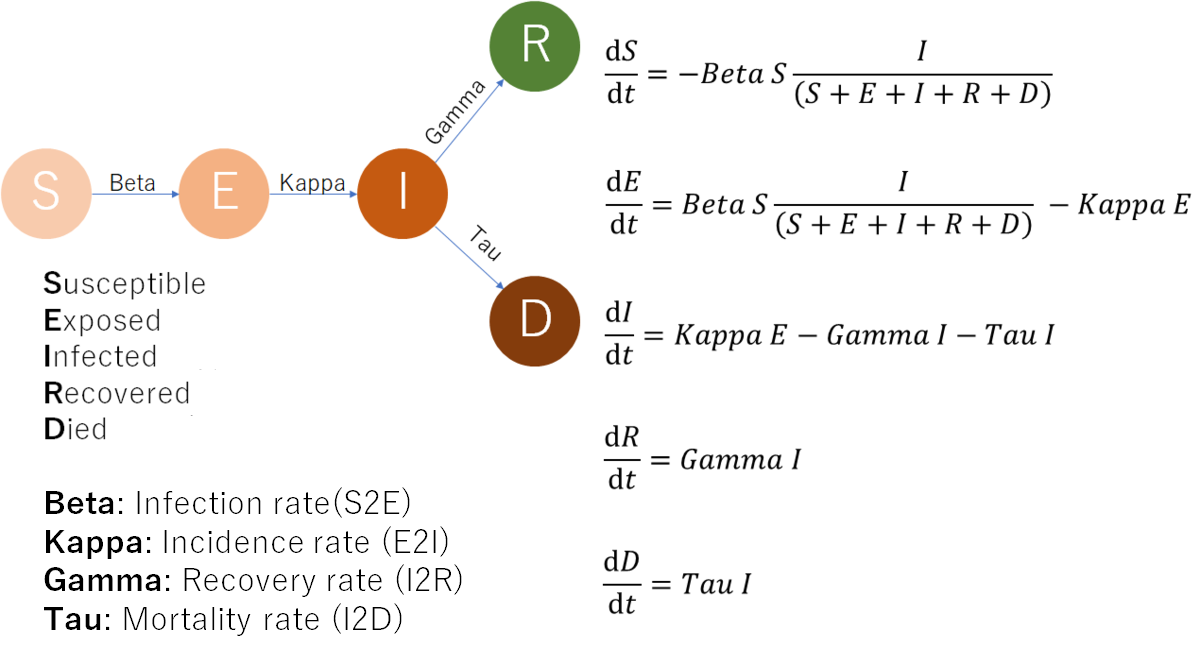

In [ ]:
Confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
Death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
Recover = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

# Data cleaning

Settings to show the full dataset when print()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

remove unnecessary columns

In [ ]:
Confirmed.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Death.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Recover.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])

US

In [ ]:

us_confirmed = Confirmed[Confirmed['Country/Region'] == 'US']
us_confirmed = us_confirmed.T.reset_index()
us_confirmed = us_confirmed.iloc[1:]
us_confirmed.columns = ['date', 'positive']

us_death = Death[Death['Country/Region'] == 'US']
us_death = us_death.T.reset_index()
us_death = us_death.iloc[1:]
us_death.columns = ['date', 'death']

us_recover = Recover[Recover['Country/Region'] == 'US']
us_recover = us_recover.T.reset_index()
us_recover = us_recover.iloc[1:]
us_recover.columns = ['date', 'recovered']

us_statu = us_confirmed.join(us_death.set_index('date'), on='date')
us_status = us_statu.join(us_recover.set_index('date'), on='date')
us_status.reset_index(inplace=True, drop=True)

# The modified SEIR Model

In a closed population without births or deaths, the SEIR model is: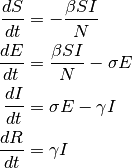



In the case of COVID-19, the viral carriers ("exposed population) do not exhibit symptoms, yet are infectious. So, the SEIR model is modified as below:


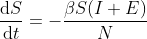

We included the "exposed population" in the first and second formula, because it participates in the viral transmission.

Accordingly, we modified the functions:

In [ ]:
# FUNCTION 
def seir_model_ode(y, t, params): 
    '''
    Arguments:
    - y: dependent variables
    - t: independent variable (time)
    - params: Model parameters
    '''
    # Parameters to find
    infection_rate = params[0]
    recovery_rate = params[1]
    exposed_rate = params[2]
    
    # Y variables
    s = y[0]
    e = y[1]
    i = y[2]
    r = y[3]
    
    # SIR EDO System 
    dsdt = -exposed_rate*s*(i+e) 
    dedt = (exposed_rate*s*(i+e)) - (infection_rate*e)
    didt = (infection_rate*e) - (recovery_rate*i)
    drdt = recovery_rate*i
    
    # Return our system
    return (dsdt, dedt, didt, drdt)

In [ ]:
# FUNCTION - Calculate SEIR Model in t (time as days) based on given parameters
def calculate_seir_model(params, t, initial_condition):
    # Create an alias to our seir ode model to pass params to try
    seir_ode = lambda y,t:seir_model_ode(y, t, params)
    
    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func=seir_ode, y0=initial_condition, t=t)
    
    # Return results
    return ode_result

In [ ]:
# FUNCTION - Auxiliar function to find the best parameters
def fit_seir_model(params_to_fit, t, initial_condition, i_r_true):
    # Calculate ODE solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    fit_result = calculate_seir_model(params_to_fit, t, initial_condition)
    
    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    residual_i = i_r_true[0] - fit_result[:,2]
    residual_r = i_r_true[1] - fit_result[:,3]

    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_r))
    
    # Return results
    return residual

In [ ]:
def countryLockdown(N, status,lockdownDay,countryName):
    
    """inputs:
    N: population in the country
    status: dataframe of the country
    lockdownDay: number of days since begining of data to the date of lockdown
    """
    
    # Define Initial Condition (necessary for ODE solve)
    I_start = status.loc[0, 'positive']/N
    E_start = (status.loc[14, 'positive'] - status.loc[0, 'positive'])/N
    S_start = 1 - E_start - I_start
    R_start = status.loc[0, 'recovered']/N

    ## Set this values as a tuple
    ic = (S_start, E_start, I_start, R_start)
    # Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
    beforelockdown=status.loc[0:lockdownDay]
    afterlockdown=status.loc[lockdownDay+1:]
    i_r_true_bf = (list(beforelockdown['positive']/N), list(beforelockdown['recovered']/N))
    i_r_true_af = (list(afterlockdown['positive']/N), list(afterlockdown['recovered']/N))
    # Define a time array measure in days
    time_opt_bf = range(0, lockdownDay+1)
    time_opt_af = range(0, len(afterlockdown))
    time_opt =range(0,len(status))
    # define initial condition after lockdown
    I_start_af = status.loc[len(beforelockdown), 'positive']/N
    E_start_day=min(len(status['date']),len(beforelockdown)+14)
    E_start_af = (status.loc[E_start_day, 'positive'] - status.loc[len(beforelockdown), 'positive'])/N
    S_start_af = 1 - E_start_af - I_start_af
    R_start_af = status.loc[len(beforelockdown), 'recovered']/N
    ## Set this values as a tuple
    ic_af = (S_start_af, E_start_af, I_start_af, R_start_af)
    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.01, 0.001, 0.01]
    optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt_bf, ic, i_r_true_bf),
                                          ftol=1.49012e-15)
    optimal_params_af, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt_af, ic_af, i_r_true_af),
                                          ftol=1.49012e-15)
    print('## '+countryName+' before lockdown')
    print('Optimize infection rate: ', optimal_params[0])
    print('Optimize recovered rate: ', optimal_params[1])
    print('Optimize exposed rate: ', optimal_params[2])
    print('## '+countryName+' after lockdown')
    print('Optimize infection rate: ', optimal_params_af[0])
    print('Optimize recovered rate: ', optimal_params_af[1])
    print('Optimize exposed rate: ', optimal_params_af[2])
    
    # Fit test
    ## Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    ir_af = optimal_params_af[0]
    rr_af = optimal_params_af[1]
    er_af = optimal_params_af[2]
    ## Calculate a curve based on those parameters
    fit_result_bf = calculate_seir_model((ir, rr, er), time_opt_bf, ic)
    fit_result_af = calculate_seir_model((ir_af, rr_af, er_af), time_opt_af, ic_af)
    ## Define plot object
   
    plt.figure(figsize=[10,10])
    ## Plot real and predicted infection
    plt.plot(time_opt, i_r_true_bf[0]+i_r_true_af[0], 'ro', markersize = 1)
    plt.plot(time_opt, np.hstack((fit_result_bf[:,2],fit_result_af[:,2])), 'c')
    plt.legend(['Real infection', 'Predicted infection'],loc=2, fontsize=8)
    plt.title('Infected cases - '+countryName,fontsize=20)
    plt.xlabel('Days since Jan-22-2020', fontsize=12)
    plt.ylabel('Proportion of population', fontsize=12)
    
    
    ## Plot real and predicted recover
    plt.figure(figsize=[10,10])
    plt.plot(time_opt, i_r_true_bf[1]+i_r_true_af[1], 'ro', markersize = 1)
    plt.plot(time_opt, np.hstack((fit_result_bf[:,3],fit_result_af[:,3])), 'g')
    plt.legend(['Real recover', 'Predicted recover'],loc=2, fontsize=8)
    plt.title('Recovered cases - '+countryName,fontsize=20);
    plt.xlabel('Days since Jan-22-2020', fontsize=12)
    plt.ylabel('Proportion of population', fontsize=12)
    
    # Prediction
    ## Get prediction full period time in datetime object and the convert to string
    datetime_pred = pd.date_range(start="2020-02-01",end="2021-01-01", freq='D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir_af, rr_af, er_af), pred_range, ic_af)
    pred_death = (pred_result[:,1]+pred_result[:,2])*0.05 # based on 5% death rate
    time_axis = [pred_time[i] for i in[0, 29, 60, 90, 121, 151, 182, 213, 243, 274, 304, 335]]
    time_labels = ['Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']
    ## Plot SEIR
    plt.figure(figsize=[20,10])
    plt.plot(pred_time, pred_result[:,0],color='blue') #susceptible
    plt.plot(pred_time, pred_result[:,1],color='red') #exposed
    plt.plot(pred_time, pred_result[:,2],color='cyan') #infected
    plt.plot(pred_time, pred_result[:,3],color='green') #recovered
    plt.plot(pred_time, pred_death,color='black')
    plt.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected','Recovered','Death'], fontsize=8)
    plt.title('SEIR predictions', fontsize=20)
    plt.xlabel('Month', fontsize=15)
    plt.ylabel('Proportion of population', fontsize=15)
    plt.xticks(time_axis, time_labels, rotation='vertical');
 

# Case study
# United States

In [ ]:
countryLockdown(328*1e6,us_status,58,'US')